# Purporse

We are going to show how to reduce the number of dimension in order to plot them in a 2D dimention. The best article that I could find that explain t- sne is this: https://distill.pub/2016/misread-tsne/

So we are going to add some code and analyse some of the data we have already work through here.

Because github doen't show interactive graph we are going to export these graph, the first blocks of code are for doing exactly that.

In [1]:
# pip install --upgrade "kaleido==0.1.*"

In [2]:
import plotly.io as pio


pio.renderers.default = "svg"

import os

if not os.path.exists("images_tsne_(1)"):
    os.mkdir("images_tsne_(1)")

In [3]:
images=str("images_tsne_(1)")

In [4]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
# new library, we haven't used this one before in this repo
from sklearn.preprocessing import TargetEncoder
from sklearn.manifold import TSNE
import plotly.express as px


In [5]:
# Read the data
# This data you can find here: https://www.kaggle.com/c/home-data-for-ml-course/data

X_full = pd.read_csv('train.csv', index_col='Id')

# SalePrice is the target, if there is no target eliminate row associated with it
X_full.dropna(axis=0, subset=['SalePrice'], inplace=True)
prices = X_full.SalePrice
X = X_full.copy()
X.drop(['SalePrice'], axis=1, inplace=True)

In [6]:
X.shape

(1460, 79)

In [7]:
def transforming_tsne(X,y,perplexity=30,n_iter=1000,n_components=2):
    
    # for SVD it is best to scale all numerical values.
    
    numerical_col = [col for col in X.columns if str(X[col].dtypes)!='object' ]
    categorical_col = [col for col in X.columns if str(X[col].dtypes)=='object' ]
    

    numerical_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", KNNImputer(n_neighbors=3))
      ]
        )
    
    categorical_transformer =  Pipeline(steps=[
        #('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
        ('encoder',TargetEncoder(smooth="auto",target_type='continuous'))
    ])

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    tsne = TSNE(n_components=n_components,perplexity=perplexity, random_state=42,learning_rate=1000,n_iter=n_iter)
    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('tsne',tsne)
                         ])

    # we need y because of TargetEncoder
    
    X_tsne = pipe.fit_transform(X,y)
    
  
    return  X_tsne,pipe['tsne']

 divergence: 1.072563648223877 for perplexity of :5


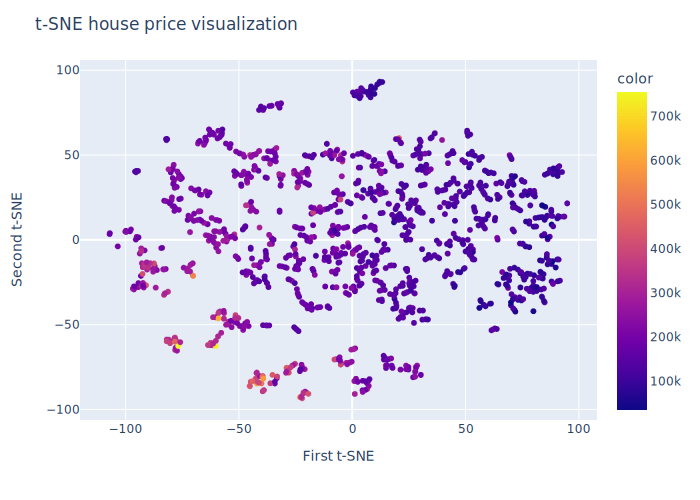

 divergence: 1.0961518287658691 for perplexity of :20


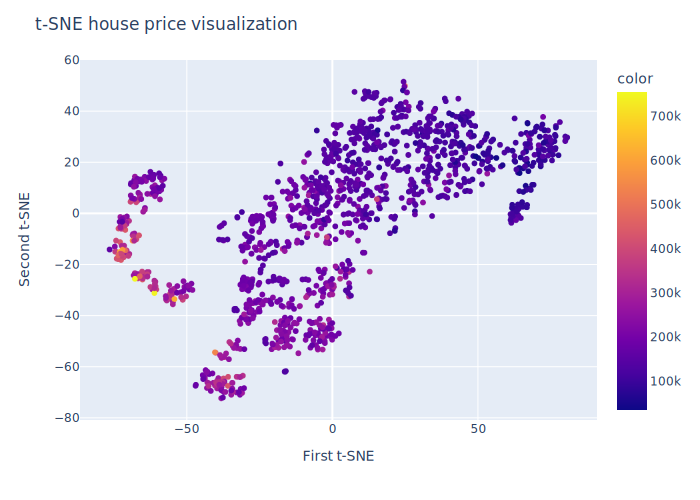

 divergence: 1.053621768951416 for perplexity of :30


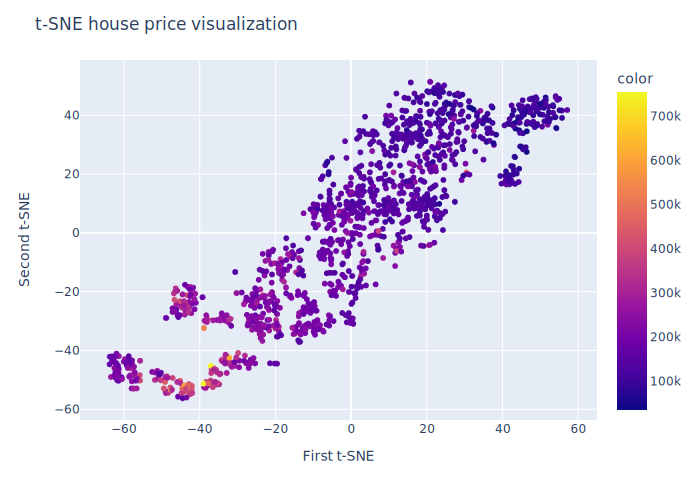

 divergence: 0.9969399571418762 for perplexity of :40


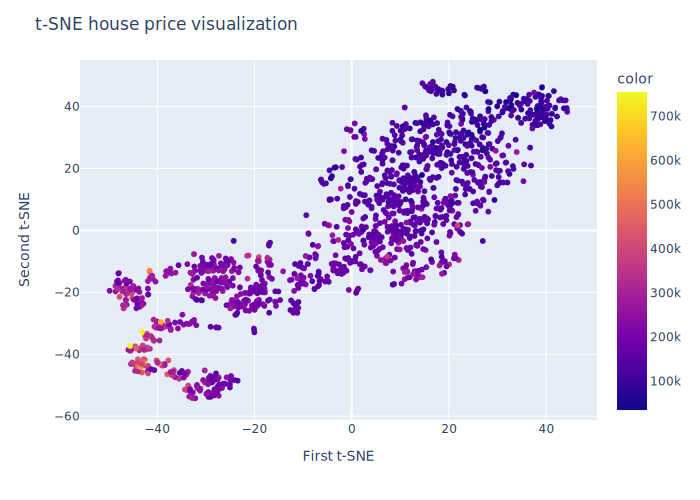

 divergence: 1.0020604133605957 for perplexity of :50


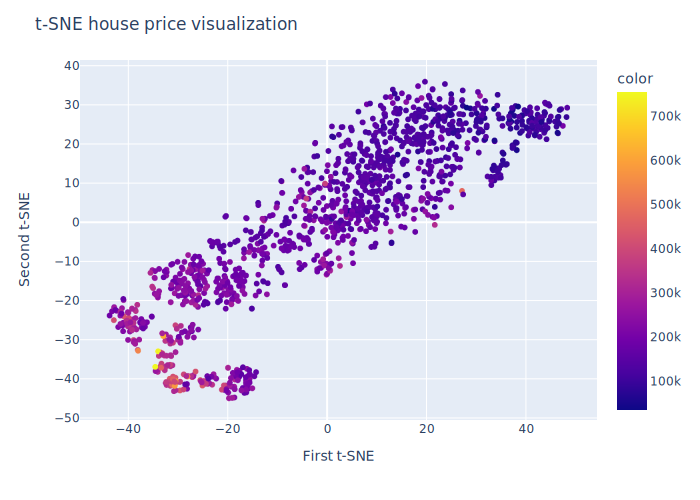

 divergence: 0.7638096809387207 for perplexity of :100


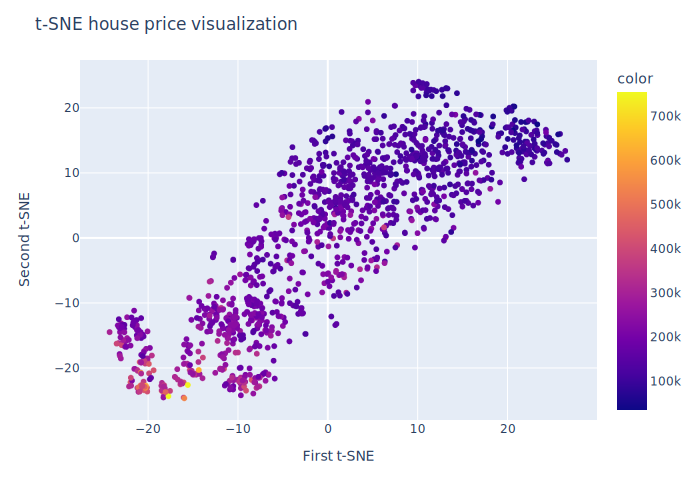

In [8]:
perplexities = [5,20,30,40,50,100] 
divergencies = []
for perplexity in perplexities: 
    tsne_X,tsne = transforming_tsne(X,prices,perplexity=perplexity)
    divergencies.append(tsne.kl_divergence_)
    print(f" divergence: {tsne.kl_divergence_} for perplexity of :{perplexity}")
    fig = px.scatter(x=tsne_X[:, 0], y=tsne_X[:, 1], color=prices)
    fig.update_layout(
        title="t-SNE house price visualization",
        xaxis_title="First t-SNE",
        yaxis_title="Second t-SNE",
    )
    fig.show()
    fig.write_html(f"{images}/tsne_perplexity_{perplexity}.html")

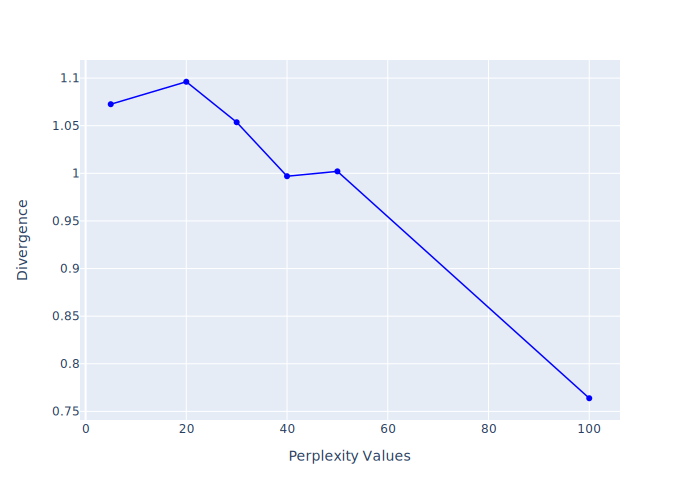

In [9]:
fig = px.line(x=perplexities, y=divergencies, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="blue", line_width=1.5)
fig.show()
fig.write_html(f"{images}/tsne_perplexity_vs_divergence.html")

 divergence: 4.234613418579102 for perplexity of :5


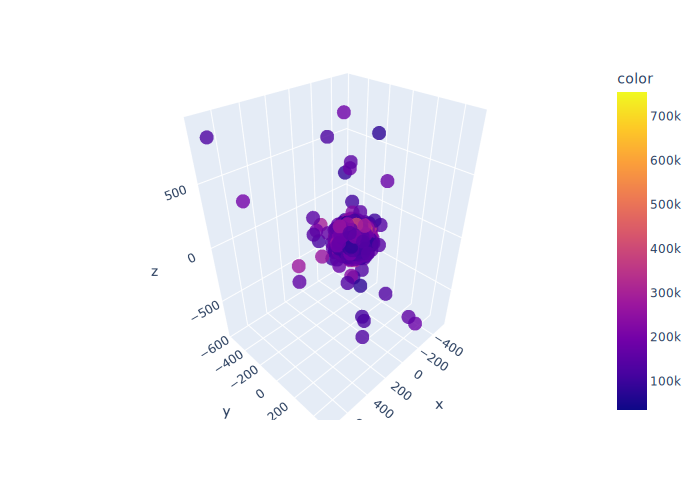

 divergence: 3.4963104724884033 for perplexity of :20


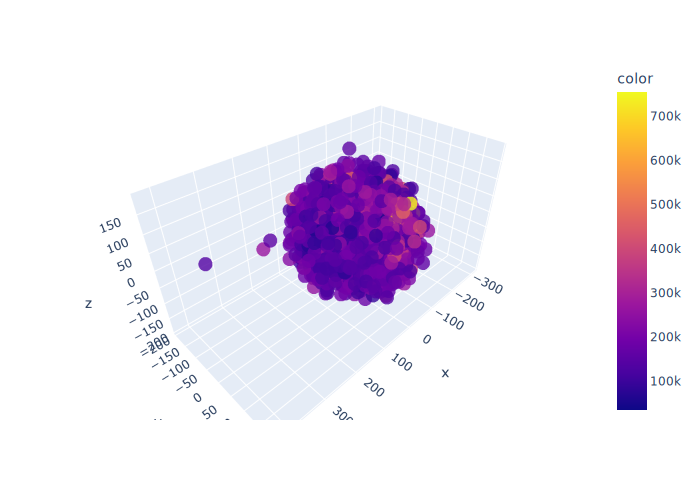

 divergence: 3.328995704650879 for perplexity of :30


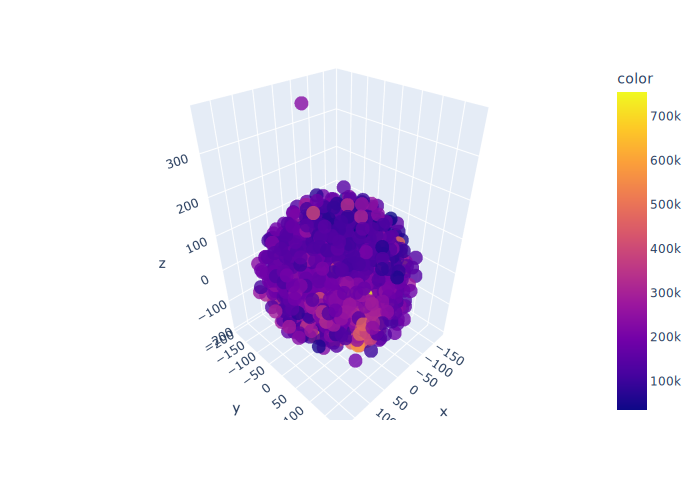

 divergence: 3.3326356410980225 for perplexity of :40


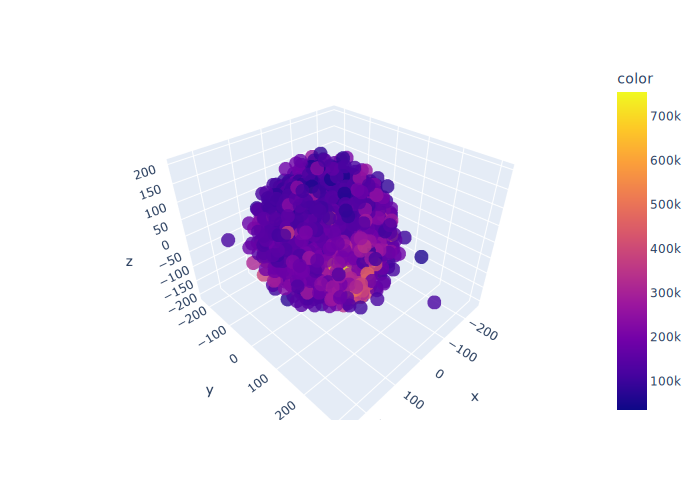

 divergence: 3.2201249599456787 for perplexity of :50


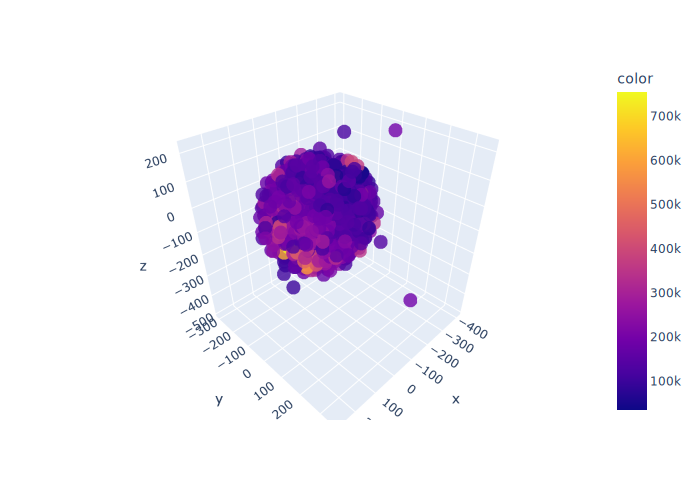

In [10]:
perplexities = [5,20,30,40,50] 
divergencies = []
for perplexity in perplexities: 
    tsne_X,tsne = transforming_tsne(X,prices,perplexity=perplexity,n_components=3)
    divergencies.append(tsne.kl_divergence_)
    print(f" divergence: {tsne.kl_divergence_} for perplexity of :{perplexity}")
    fig = px.scatter_3d(x=tsne_X[:, 0], y=tsne_X[:, 1], z=tsne_X[:, 2], color=prices, opacity=0.8)
    fig.show()
    fig.update_layout(
        title="t-SNE house price visualization",
        xaxis_title="First t-SNE",
        yaxis_title="Second t-SNE"
    )
    fig.write_html(f"{images}/tsne_3D__perplexity_{perplexity}.html")

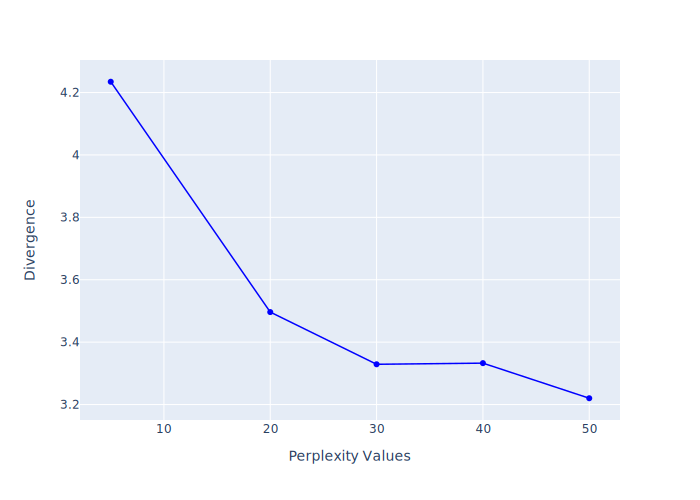

In [11]:
fig = px.line(x=perplexities, y=divergencies, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="blue", line_width=1.5)
fig.show()
fig.write_html(f"{images}/tsne_3D_perplexity_vs_divergence.html")

The original paper recommends using perplexity values between 5 and 50 so we will stick with that from here and onwards. 

One important aspects is **how to read the information provided by tsne**. The other aspects is how **not** to read it. 
I strongly suggest that you see the website that I put at the beginning of this notebook.

Firstly we notice that the better divergence we got with the value 5 (it is better with 100 but we will stick as we said before with values between 5-50). This is a very important hyperparameter of the model. That saying it loosely translate as the numbers of neighbors each point has or better say the model expected to have. 

Now talking about what we actually see when we are looking at this graph, we see that prices with similar prices got cluster together (relatively easy to see in the 2 D plot with perplexity 5). That means that those points in the X-space in the higher dimension are "nearby" or has "similarities" between them. And that similarity translate that they have a high prices.

Notice that as the resource provided the distance between cluster don't mean anything, the important thing are the points that are actually together. So we cannot conclude that points that are far apart for the cluster of high value are lower value themselves.

Conclusion:

TSNE is a nice way to see if there are cluster in our data. It is a good beginning point to understand the structure of it and to see in just two dimension if there any distinct cluster. 

In this particular example we saw some houses cluster with a high value price, so we our going to explore if we can actually find these cluster and what are some of their characteristic.


In this final block of code we just run a little longer our tsne with the perplexity that got us the best divergence score. And with a graph 2-D that are way easy to look.

 divergence: 0.9640997648239136 for perplexity of :50


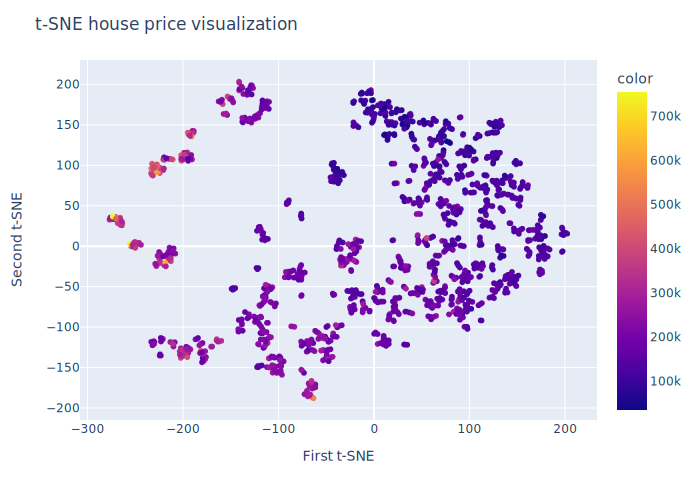

In [12]:
# In the main folder
tsne_X,tsne = transforming_tsne(X,prices,perplexity=5,n_iter=20000)
divergencies.append(tsne.kl_divergence_)
print(f" divergence: {tsne.kl_divergence_} for perplexity of :{perplexity}")
fig = px.scatter(x=tsne_X[:, 0], y=tsne_X[:, 1], color=prices)
fig.update_layout(
    title="t-SNE house price visualization",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()